# Data Inspection

A one stop shop notebook to interrogate the outputs of the model on the cloud

In [1]:
import numpy as np
import torch
import cv2
import sys
import pickle
import os
import pyvista as pv
from pyvista import examples
import re
from itkwidgets import view
import h5py as h5
import matplotlib.pyplot as plt


In [2]:
from pytorch3d.ops import cubify

In [3]:
sys.path

['',
 '/home/ubuntu/anaconda3/envs/pytorch3d_latest_p36/lib/python36.zip',
 '/home/ubuntu/anaconda3/envs/pytorch3d_latest_p36/lib/python3.6',
 '/home/ubuntu/anaconda3/envs/pytorch3d_latest_p36/lib/python3.6/lib-dynload',
 '/home/ubuntu/anaconda3/envs/pytorch3d_latest_p36/lib/python3.6/site-packages',
 '/home/ubuntu/anaconda3/envs/pytorch3d_latest_p36/lib/python3.6/site-packages/IPython/extensions',
 '/home/ubuntu/.ipython',
 '/home/ubuntu/anaconda3/envs/pytorch3d_latest_p36/lib/python3.6/site-packages/itk/Configuration/..',
 '/home/ubuntu/anaconda3/envs/pytorch3d_latest_p36/lib/python3.6/site-packages/itk/Configuration/../../lib']

## Directories 

In [4]:
data_path = '/data/IM-NET-pytorch/data/all_vox256_img/'
data_files = os.listdir(data_path)
data_files;

In [5]:
reg_data = re.compile('\w*.hdf5')

datafiles_list = []
for filename in data_files:
    if reg_data.match(filename) is not None:
        datafiles_list.append(filename)

datafiles_list

['all_vox256_img_test.hdf5', 'all_vox256_img_train.hdf5']

In [6]:
output_path = '/data/IM-NET-pytorch/data/all_vox256_img/'
output_files = os.listdir(output_path);

In [7]:
reg_vox = re.compile('\w*_vox.ply')

output_vox = []
for filename in output_files:
    if reg_vox.match(filename) is not None:
        output_vox.append(filename)

output_vox;

Examine data format of precomputed hdf5 data files

In [8]:
data_file = h5.File(data_path + datafiles_list[0], 'r')

In [9]:
def recursive_directory(entity,  numtab = 0):
    if isinstance(entity, h5.Group):
        for key in entity.keys():
            print('\t'*numtab + key)
            new_tab_level = numtab + 1
            recursive_directory(entity[key], new_tab_level)
    elif isinstance(entity, h5.Dataset):
        print('\t' + str(entity.shape))
    
    return

In [10]:
recursive_directory(data_file, 0)

pixels
	(8762, 24, 137, 137)
points_16
	(8762, 4096, 3)
points_32
	(8762, 4096, 3)
points_64
	(8762, 16384, 3)
values_16
	(8762, 4096, 1)
values_32
	(8762, 4096, 1)
values_64
	(8762, 16384, 1)
voxels
	(8762, 64, 64, 64, 1)


## Images

In [11]:
data_file['pixels'].shape

(8762, 24, 137, 137)

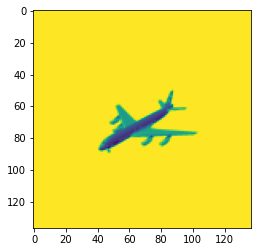

In [12]:
plt.imshow(data_file['pixels'][0][0,:,:])

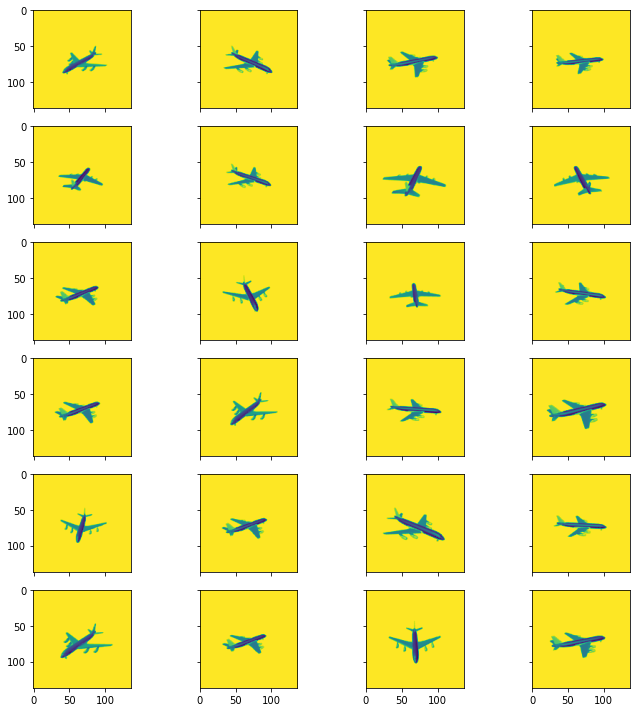

In [13]:
fig, axs = plt.subplots(nrows=6, ncols=4, sharex=True, sharey=True, figsize=(10,10))
images = data_file['pixels'][0][...]
for ax, im in zip(axs.flatten(), range(24)):
    ax.imshow(images[im,:,:])
    
fig.tight_layout()

In [20]:
voxels = data_file['voxels'][10, ...]
print(voxels.dtype)
voxels_mask = voxels.reshape(voxels.shape[0:3]) == 1
grid_axis = np.linspace(0,3**.5, 64)
xxx, yyy, zzz = np.meshgrid(grid_axis, grid_axis, grid_axis)
xxx = xxx[voxels_mask]
yyy = yyy[voxels_mask]
zzz = zzz[voxels_mask]

voxel_point_cloud = np.stack([xxx, yyy, zzz], axis=1)
print(voxel_point_cloud.shape)

uint8
(1623, 3)


In [24]:
point_cloud = pv.PolyData(voxel_point_cloud)
surface = point_cloud.delaunay_2d()

# Plot using the ITKplotter
pl = pv.PlotterITK()
pl.add_mesh(surface, smooth_shading=True)
pl.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
voxels = data_file['voxels'][0, ...]
print(voxels.dtype)
voxels = voxels.reshape(voxels.shape[0:3])
grid = pv.StructuredGrid()
grid.origin = (0, 0, 0)
grid.spacing = np.ones(3)*3**.5/64
grid.dimensions = [65,65,65]
grid.cell_arrays["values"] = voxels.flatten(order="F") 
#grid.plot(show_edges=True)

# Plot using the ITKplotter
pl = pv.PlotterITK()
pl.add_mesh(grid, smooth_shading=True)
pl.show(True)

## Output Models

In [14]:
len(output_vox)

19

In [15]:
select_output_num = 1

In [19]:
mesh = pv.read(output_path + output_vox[select_output_num])
z = mesh.points[:, 2]

# Plot using the ITKplotter
pl = pv.PlotterITK()
pl.add_mesh(mesh, smooth_shading=True)
pl.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [18]:
data_file

mesh = pv.read(output_path + output_vox[select_output_num])
z = mesh.points[:, 2]

# Plot using the ITKplotter
pl = pv.PlotterITK()
pl.add_mesh(mesh, smooth_shading=True)
pl.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…